In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, Dataset
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
from torchinfo import summary

In [3]:
def set_seed(seed=0):
    """Sets the seed for reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
os.makedirs('models_refactored', exist_ok=True)
os.makedirs('results_refactored', exist_ok=True)

Using device: cuda


In [11]:
# Data parameters
MNIST_IMG_SIZE = 28
MNIST_INPUT_DIM = MNIST_IMG_SIZE * MNIST_IMG_SIZE
MNIST_OUTPUT_DIM = 10
MNIST_MEAN = (0.1307,)
MNIST_STD = (0.3081,)
AUGMENT_PAD = 2

# Model parameters
TEACHER_HIDDEN = 1200 # As per paper Section 3
STUDENT_HIDDEN = 400
TEACHER_DROPOUT_INPUT = 0.0
TEACHER_DROPOUT_HIDDEN = 0.0
STUDENT_DROPOUT_INPUT = 0.0 # Student baseline usually has no dropout
STUDENT_DROPOUT_HIDDEN = 0.0

# Training parameters
BATCH_SIZE = 128
LEARNING_RATE = 0.01 #  (SGD default, adjust if using Adam)
WEIGHT_DECAY = 1e-5
MOMENTUM = 0.9      # (for SGD)
LR_DECAY_FACTOR = 0.95
EPOCHS_TEACHER = 30
EPOCHS_STUDENT = 30
OPTIMIZER_TYPE = 'SGD' # Use 'Adam' or 'SGD' as in the source
PRINT_FREQ = 100 # How often to print train loss/acc

# Distillation parameters
TEMPERATURES_TO_TEST = [1, 5, 10, 15, 20, 25, 30] # Extended range
DEFAULT_T = 10
ALPHA = 0.5                   # Weight for soft target loss (KD term)

# Omitted Class experiment
OMITTED_DIGIT = 3            # Digit to omit from student's training set (KD)
OMITTED_DIGIT_BASELINE = 4    # Different digit for baseline omission test

 ## 3. Data Loading and Preprocessing

In [12]:

transform_teacher_train = transforms.Compose([
    transforms.RandomCrop(MNIST_IMG_SIZE, padding=AUGMENT_PAD), # Similar augmentation
    transforms.ToTensor(),
    transforms.Normalize(MNIST_MEAN, MNIST_STD)
])


transform_student_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MNIST_MEAN, MNIST_STD)
])


train_val_dataset_teacher = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_teacher_train)
train_val_dataset_student = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_student_test)
test_dataset_student = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_student_test)

num_total = len(train_val_dataset_student)
num_train = int(0.95 * num_total)
num_val = num_total - num_train
train_indices, val_indices = torch.utils.data.random_split(range(num_total), [num_train, num_val])


train_dataset_teacher = Subset(train_val_dataset_teacher, train_indices.indices)
train_dataset_student = Subset(train_val_dataset_student, train_indices.indices)
val_dataset_student = Subset(train_val_dataset_student, val_indices.indices)

print(f"Teacher Training set size: {len(train_dataset_teacher)}")
print(f"Student Training set size: {len(train_dataset_student)}")
print(f"Student Validation set size: {len(val_dataset_student)}")
print(f"Student Test set size: {len(test_dataset_student)}")

train_loader_teacher = DataLoader(train_dataset_teacher, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

train_loader_student = DataLoader(train_dataset_student, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader_student = DataLoader(val_dataset_student, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader_student = DataLoader(test_dataset_student, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

def get_omitted_digit_loader(original_dataset, omitted_digit, batch_size, shuffle=True):
    """Creates a DataLoader excluding samples of a specific digit."""
    indices = [i for i, (img, label) in enumerate(original_dataset) if label != omitted_digit]
    subset = Subset(original_dataset, indices)
    print(f"Dataset size after omitting digit {omitted_digit}: {len(subset)}")
    return DataLoader(subset, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)

100%|██████████| 9.91M/9.91M [00:10<00:00, 901kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 240kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.55MB/s]

Teacher Training set size: 57000
Student Training set size: 57000
Student Validation set size: 3000
Student Test set size: 10000


## 4. Model Definitions

In [13]:
class TeacherNet(nn.Module):
    def __init__(self, input_dim=MNIST_INPUT_DIM, hidden_units=TEACHER_HIDDEN, output_dim=MNIST_OUTPUT_DIM,
                 dropout_input=TEACHER_DROPOUT_INPUT, dropout_hidden=TEACHER_DROPOUT_HIDDEN):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, output_dim)
        self.dropout_input_rate = dropout_input
        self.dropout_hidden_rate = dropout_hidden


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.dropout(x, p=self.dropout_input_rate, training=self.training)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_hidden_rate, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout_hidden_rate, training=self.training)
        x = self.fc3(x)
        return x

class StudentNet(nn.Module):
    def __init__(self, input_dim=MNIST_INPUT_DIM, hidden_units=STUDENT_HIDDEN, output_dim=MNIST_OUTPUT_DIM,
                 dropout_input=STUDENT_DROPOUT_INPUT, dropout_hidden=STUDENT_DROPOUT_HIDDEN):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units)
        self.fc2 = nn.Linear(hidden_units, output_dim)
        self.dropout_input_rate = dropout_input
        self.dropout_hidden_rate = dropout_hidden

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.dropout(x, p=self.dropout_input_rate, training=self.training)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_hidden_rate, training=self.training)
        x = self.fc2(x)
        return x


## 5. Utility Functions (Evaluation, Loss)

In [14]:
def evaluate_accuracy(model: nn.Module, dataloader: DataLoader, device: torch.device, class_specific_digit: int = None):
    """Evaluates model accuracy on the provided dataloader."""
    model.eval()
    correct = 0
    total = 0
    correct_specific = 0
    total_specific = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if class_specific_digit is not None:
                mask = (labels == class_specific_digit)
                total_specific += mask.sum().item()
                correct_specific += (predicted[mask] == labels[mask]).sum().item()

    accuracy = 100 * correct / total
    if class_specific_digit is not None:
        accuracy_specific = 100 * correct_specific / total_specific if total_specific > 0 else 0.0
        return accuracy, accuracy_specific
    else:
        return accuracy

def distillation_loss_fn(student_logits, teacher_logits, hard_labels, temp, alpha):
    """
    Computes the distillation loss.
    Loss = alpha * KLDiv(student_soft, teacher_soft) * T^2 + (1-alpha) * CrossEntropy(student_logits, hard_labels)
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("alpha must be between 0 and 1")

    teacher_probs_soft = F.softmax(teacher_logits / temp, dim=1)
    student_log_probs_soft = F.log_softmax(student_logits / temp, dim=1)

    # reduction='batchmean' averages the loss over the batch *before* multiplying by T*T
    # This matches the scaling behavior described in the Hinton paper.
    soft_loss = nn.KLDivLoss(reduction='batchmean')(student_log_probs_soft, teacher_probs_soft.detach()) * (temp * temp)

    # Hard loss component (Cross Entropy with ground truth labels)
    hard_loss = nn.CrossEntropyLoss()(student_logits, hard_labels)

    # Weighted combination
    total_loss = alpha * soft_loss + (1 - alpha) * hard_loss
    return total_loss

## 6. Requirement 1: Baseline Models (Teacher & Student)

### 6.1 Instantiate and Analyze Models

In [9]:
pip install ptflops


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [16]:
from ptflops import get_model_complexity_info

macs, params = get_model_complexity_info(teacher_baseline, (1, 28, 28), as_strings=True, print_per_layer_stat=True)
print(f'Teacher Model:\nFLOPs: {macs}\nParams: {params}')
macs, params = get_model_complexity_info(student_baseline, (1, 28, 28), as_strings=True, print_per_layer_stat=True)
print(f'Student Model:\nFLOPs: {macs}\nParams: {params}')


TeacherNet(
  2.4 M, 100.000% Params, 2.4 MMac, 99.900% MACs, 
  (fc1): Linear(942.0 k, 39.328% Params, 942.0 KMac, 39.289% MACs, in_features=784, out_features=1200, bias=True)
  (fc2): Linear(1.44 M, 60.170% Params, 1.44 MMac, 60.110% MACs, in_features=1200, out_features=1200, bias=True)
  (fc3): Linear(12.01 k, 0.501% Params, 12.01 KMac, 0.501% MACs, in_features=1200, out_features=10, bias=True)
)
Teacher Model:
FLOPs: 2.4 MMac
Params: 2.4 M
StudentNet(
  318.01 k, 100.000% Params, 318.01 KMac, 99.874% MACs, 
  (fc1): Linear(314.0 k, 98.739% Params, 314.0 KMac, 98.615% MACs, in_features=784, out_features=400, bias=True)
  (fc2): Linear(4.01 k, 1.261% Params, 4.01 KMac, 1.259% MACs, in_features=400, out_features=10, bias=True)
)
Student Model:
FLOPs: 318.41 KMac
Params: 318.01 k


### 6.2 Train Teacher Model

In [17]:
teacher_model_path = 'models_refactored/teacher_model_final.pth'
results_teacher_path = 'results_refactored/teacher_results.npy'

if os.path.exists(teacher_model_path):
    print(f"Loading pre-trained teacher model from {teacher_model_path}")
    teacher_baseline.load_state_dict(torch.load(teacher_model_path, map_location=device))
    teacher_train_results = np.load(results_teacher_path, allow_pickle=True).item()
else:
    print("--- Training Teacher Model ---")
    teacher_baseline.to(device)
    if OPTIMIZER_TYPE == 'Adam':
         optimizer = optim.Adam(teacher_baseline.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
         # Adam usually doesn't need aggressive LR decay like SGD with momentum
         scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, EPOCHS_TEACHER // 3), gamma=0.5)
    else:
        optimizer = optim.SGD(teacher_baseline.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR_DECAY_FACTOR)

    criterion = nn.CrossEntropyLoss()
    teacher_train_losses = []
    teacher_train_accs = []
    teacher_val_accs = []

    for epoch in range(EPOCHS_TEACHER):
        teacher_baseline.train()
        batch_losses = []
        batch_accs = []
        progress_bar = tqdm(train_loader_teacher, desc=f"Teacher Epoch {epoch+1}/{EPOCHS_TEACHER}", leave=False)

        for i, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = teacher_baseline(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == labels).float().mean().item()

            batch_losses.append(loss.item())
            batch_accs.append(accuracy)

            if (i + 1) % PRINT_FREQ == 0:
                 progress_bar.set_postfix(loss=f"{np.mean(batch_losses[-PRINT_FREQ:]):.3f}", acc=f"{np.mean(batch_accs[-PRINT_FREQ:]):.3f}")

        epoch_train_loss = np.mean(batch_losses)
        epoch_train_acc = np.mean(batch_accs)
        teacher_train_losses.append(epoch_train_loss)
        teacher_train_accs.append(epoch_train_acc)
        epoch_val_acc = evaluate_accuracy(teacher_baseline, val_loader_student, device)
        teacher_val_accs.append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{EPOCHS_TEACHER} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.2f}%")

        scheduler.step()

    print("--- Finished Teacher Training ---")
    torch.save(teacher_baseline.state_dict(), teacher_model_path)
    teacher_train_results = {'train_loss': teacher_train_losses, 'train_acc': teacher_train_accs, 'val_acc': teacher_val_accs}
    np.save(results_teacher_path, teacher_train_results)

teacher_test_accuracy = evaluate_accuracy(teacher_baseline, test_loader_student, device)
print(f"\nFinal Teacher Model Test Accuracy: {teacher_test_accuracy:.2f}%")

--- Training Teacher Model ---


Teacher Epoch 1/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 0.0429, Train Acc: 0.9868, Val Acc: 98.13%


Teacher Epoch 2/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.0453, Train Acc: 0.9858, Val Acc: 98.30%


Teacher Epoch 3/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.0414, Train Acc: 0.9869, Val Acc: 98.73%


Teacher Epoch 4/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.0401, Train Acc: 0.9874, Val Acc: 98.83%


Teacher Epoch 5/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.0379, Train Acc: 0.9883, Val Acc: 98.83%


Teacher Epoch 6/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.0350, Train Acc: 0.9890, Val Acc: 98.80%


Teacher Epoch 7/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.0330, Train Acc: 0.9898, Val Acc: 98.83%


Teacher Epoch 8/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.0313, Train Acc: 0.9905, Val Acc: 98.83%


Teacher Epoch 9/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.0317, Train Acc: 0.9902, Val Acc: 99.03%


Teacher Epoch 10/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.0296, Train Acc: 0.9910, Val Acc: 99.10%


Teacher Epoch 11/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.0282, Train Acc: 0.9912, Val Acc: 99.30%


Teacher Epoch 12/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.0265, Train Acc: 0.9920, Val Acc: 99.03%


Teacher Epoch 13/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.0254, Train Acc: 0.9926, Val Acc: 99.10%


Teacher Epoch 14/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.0252, Train Acc: 0.9926, Val Acc: 99.00%


Teacher Epoch 15/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.0236, Train Acc: 0.9932, Val Acc: 98.93%


Teacher Epoch 16/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.0236, Train Acc: 0.9928, Val Acc: 99.23%


Teacher Epoch 17/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.0213, Train Acc: 0.9936, Val Acc: 99.27%


Teacher Epoch 18/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.0221, Train Acc: 0.9938, Val Acc: 99.27%


Teacher Epoch 19/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.0213, Train Acc: 0.9939, Val Acc: 99.10%


Teacher Epoch 20/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.0193, Train Acc: 0.9946, Val Acc: 98.93%


Teacher Epoch 21/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.0199, Train Acc: 0.9941, Val Acc: 99.20%


Teacher Epoch 22/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.0187, Train Acc: 0.9944, Val Acc: 99.13%


Teacher Epoch 23/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.0192, Train Acc: 0.9949, Val Acc: 99.00%


Teacher Epoch 24/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.0183, Train Acc: 0.9948, Val Acc: 99.17%


Teacher Epoch 25/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.0172, Train Acc: 0.9951, Val Acc: 99.17%


Teacher Epoch 26/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.0177, Train Acc: 0.9948, Val Acc: 99.13%


Teacher Epoch 27/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.0167, Train Acc: 0.9955, Val Acc: 99.17%


Teacher Epoch 28/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0163, Train Acc: 0.9951, Val Acc: 99.07%


Teacher Epoch 29/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0170, Train Acc: 0.9955, Val Acc: 99.10%


Teacher Epoch 30/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0156, Train Acc: 0.9959, Val Acc: 99.17%
--- Finished Teacher Training ---

Final Teacher Model Test Accuracy: 98.96%


### 6.3 Train Student Model (Baseline)

In [18]:
student_baseline_model_path = 'models_refactored/student_baseline_final.pth'
results_student_baseline_path = 'results_refactored/student_baseline_results.npy'

if os.path.exists(student_baseline_model_path):
    print(f"Loading pre-trained student baseline model from {student_baseline_model_path}")
    student_baseline.load_state_dict(torch.load(student_baseline_model_path, map_location=device))
    student_baseline_train_results = np.load(results_student_baseline_path, allow_pickle=True).item()
else:
    print("--- Training Student Model (Baseline) ---")
    student_baseline.to(device)

    if OPTIMIZER_TYPE == 'Adam':
         optimizer = optim.Adam(student_baseline.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
         scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, EPOCHS_STUDENT // 3), gamma=0.5)
    else:
        optimizer = optim.SGD(student_baseline.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR_DECAY_FACTOR)

    criterion = nn.CrossEntropyLoss()
    student_baseline_train_losses = []
    student_baseline_train_accs = []
    student_baseline_val_accs = []

    for epoch in range(EPOCHS_STUDENT):
        student_baseline.train()
        batch_losses = []
        batch_accs = []
        progress_bar = tqdm(train_loader_student, desc=f"Student BL Epoch {epoch+1}/{EPOCHS_STUDENT}", leave=False)

        for i, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = student_baseline(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == labels).float().mean().item()
            batch_losses.append(loss.item())
            batch_accs.append(accuracy)

            if (i + 1) % PRINT_FREQ == 0:
                 progress_bar.set_postfix(loss=f"{np.mean(batch_losses[-PRINT_FREQ:]):.3f}", acc=f"{np.mean(batch_accs[-PRINT_FREQ:]):.3f}")

        epoch_train_loss = np.mean(batch_losses)
        epoch_train_acc = np.mean(batch_accs)
        student_baseline_train_losses.append(epoch_train_loss)
        student_baseline_train_accs.append(epoch_train_acc)

        epoch_val_acc = evaluate_accuracy(student_baseline, val_loader_student, device)
        student_baseline_val_accs.append(epoch_val_acc)
        print(f"Epoch {epoch+1}/{EPOCHS_STUDENT} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        scheduler.step()

    print("--- Finished Student Baseline Training ---")
    torch.save(student_baseline.state_dict(), student_baseline_model_path)
    student_baseline_train_results = {'train_loss': student_baseline_train_losses, 'train_acc': student_baseline_train_accs, 'val_acc': student_baseline_val_accs}
    np.save(results_student_baseline_path, student_baseline_train_results)

student_baseline_test_accuracy = evaluate_accuracy(student_baseline, test_loader_student, device)
print(f"\nFinal Student Model (Baseline) Test Accuracy: {student_baseline_test_accuracy:.2f}%")

--- Training Student Model (Baseline) ---


Student BL Epoch 1/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 0.3508, Train Acc: 0.9006, Val Acc: 94.27%


Student BL Epoch 2/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.1557, Train Acc: 0.9553, Val Acc: 95.80%


Student BL Epoch 3/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.1098, Train Acc: 0.9693, Val Acc: 96.63%


Student BL Epoch 4/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.0854, Train Acc: 0.9760, Val Acc: 96.97%


Student BL Epoch 5/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.0702, Train Acc: 0.9805, Val Acc: 97.57%


Student BL Epoch 6/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.0590, Train Acc: 0.9841, Val Acc: 97.37%


Student BL Epoch 7/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.0502, Train Acc: 0.9867, Val Acc: 97.57%


Student BL Epoch 8/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.0439, Train Acc: 0.9888, Val Acc: 97.63%


Student BL Epoch 9/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.0389, Train Acc: 0.9901, Val Acc: 97.80%


Student BL Epoch 10/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.0345, Train Acc: 0.9918, Val Acc: 97.90%


Student BL Epoch 11/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.0311, Train Acc: 0.9925, Val Acc: 97.67%


Student BL Epoch 12/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.0281, Train Acc: 0.9938, Val Acc: 97.93%


Student BL Epoch 13/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.0257, Train Acc: 0.9947, Val Acc: 97.97%


Student BL Epoch 14/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.0233, Train Acc: 0.9955, Val Acc: 98.00%


Student BL Epoch 15/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.0216, Train Acc: 0.9963, Val Acc: 98.07%


Student BL Epoch 16/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.0200, Train Acc: 0.9969, Val Acc: 98.17%


Student BL Epoch 17/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.0186, Train Acc: 0.9969, Val Acc: 97.97%


Student BL Epoch 18/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.0174, Train Acc: 0.9974, Val Acc: 98.17%


Student BL Epoch 19/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.0165, Train Acc: 0.9979, Val Acc: 98.07%


Student BL Epoch 20/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.0156, Train Acc: 0.9981, Val Acc: 98.07%


Student BL Epoch 21/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.0147, Train Acc: 0.9984, Val Acc: 98.17%


Student BL Epoch 22/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.0141, Train Acc: 0.9985, Val Acc: 98.00%


Student BL Epoch 23/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.0134, Train Acc: 0.9985, Val Acc: 98.13%


Student BL Epoch 24/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.0129, Train Acc: 0.9987, Val Acc: 98.10%


Student BL Epoch 25/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.0124, Train Acc: 0.9990, Val Acc: 98.17%


Student BL Epoch 26/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.0120, Train Acc: 0.9989, Val Acc: 98.10%


Student BL Epoch 27/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.0116, Train Acc: 0.9991, Val Acc: 98.13%


Student BL Epoch 28/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0112, Train Acc: 0.9992, Val Acc: 98.10%


Student BL Epoch 29/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0109, Train Acc: 0.9992, Val Acc: 98.13%


Student BL Epoch 30/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0106, Train Acc: 0.9992, Val Acc: 98.00%
--- Finished Student Baseline Training ---

Final Student Model (Baseline) Test Accuracy: 98.16%


 ## 7. Requirement 2: Knowledge Distillation

In [19]:
print(f"\n--- Starting Basic Distillation (T={DEFAULT_T}, alpha={ALPHA}) ---")

student_distilled = StudentNet().to(device)

teacher_model_kd = TeacherNet().to(device)
teacher_model_kd.load_state_dict(torch.load(teacher_model_path, map_location=device))
teacher_model_kd.eval()

if OPTIMIZER_TYPE == 'Adam':
    optimizer = optim.Adam(student_distilled.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, EPOCHS_STUDENT // 3), gamma=0.5)
else:
    optimizer = optim.SGD(student_distilled.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR_DECAY_FACTOR)

student_distilled_train_losses = []
student_distilled_train_accs = []
student_distilled_val_accs = []

for epoch in range(EPOCHS_STUDENT):
    student_distilled.train()
    batch_losses = []
    batch_accs = []
    progress_bar = tqdm(train_loader_student, desc=f"Distill Epoch {epoch+1}/{EPOCHS_STUDENT}", leave=False)

    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.no_grad():
            teacher_logits = teacher_model_kd(inputs)
        student_logits = student_distilled(inputs)

        loss = distillation_loss_fn(student_logits, teacher_logits, labels, DEFAULT_T, ALPHA)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(student_logits.data, 1)
        accuracy = (predicted == labels).float().mean().item()
        batch_losses.append(loss.item())
        batch_accs.append(accuracy)

        if (i + 1) % PRINT_FREQ == 0:
            progress_bar.set_postfix(loss=f"{np.mean(batch_losses[-PRINT_FREQ:]):.3f}", acc=f"{np.mean(batch_accs[-PRINT_FREQ:]):.3f}")

    epoch_train_loss = np.mean(batch_losses)
    epoch_train_acc = np.mean(batch_accs)
    student_distilled_train_losses.append(epoch_train_loss)
    student_distilled_train_accs.append(epoch_train_acc)

    epoch_val_acc = evaluate_accuracy(student_distilled, val_loader_student, device)
    student_distilled_val_accs.append(epoch_val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS_STUDENT} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.2f}%")
    scheduler.step()

print("--- Finished Distillation Training ---")
# Save the distilled model
distilled_model_path = f'models_refactored/student_distilled_T{DEFAULT_T}_alpha{ALPHA}_final.pth'
torch.save(student_distilled.state_dict(), distilled_model_path)
distilled_train_results = {'train_loss': student_distilled_train_losses, 'train_acc': student_distilled_train_accs, 'val_acc': student_distilled_val_accs}
np.save(f'results_refactored/student_distilled_T{DEFAULT_T}_alpha{ALPHA}_results.npy', distilled_train_results)


# Evaluate the final distilled student model on Test set
student_distilled_test_accuracy = evaluate_accuracy(student_distilled, test_loader_student, device)

print(f"\n--- Distillation Results (T={DEFAULT_T}, alpha={ALPHA}) ---")
print(f"Teacher Model Test Accuracy:         {teacher_test_accuracy:.2f}%")
print(f"Student Baseline Test Accuracy:      {student_baseline_test_accuracy:.2f}%")
print(f"Student Distilled Test Accuracy:     {student_distilled_test_accuracy:.2f}%")
improvement = student_distilled_test_accuracy - student_baseline_test_accuracy
print(f"Improvement over Baseline:           {improvement:.2f}%")


--- Starting Basic Distillation (T=10, alpha=0.5) ---


Distill Epoch 1/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 2.1908, Train Acc: 0.9237, Val Acc: 97.27%


Distill Epoch 2/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.5226, Train Acc: 0.9788, Val Acc: 98.07%


Distill Epoch 3/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.3476, Train Acc: 0.9858, Val Acc: 98.47%


Distill Epoch 4/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.2686, Train Acc: 0.9886, Val Acc: 98.50%


Distill Epoch 5/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.2267, Train Acc: 0.9907, Val Acc: 98.57%


Distill Epoch 6/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.1982, Train Acc: 0.9919, Val Acc: 98.63%


Distill Epoch 7/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.1790, Train Acc: 0.9930, Val Acc: 98.60%


Distill Epoch 8/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.1654, Train Acc: 0.9938, Val Acc: 98.63%


Distill Epoch 9/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.1546, Train Acc: 0.9943, Val Acc: 98.60%


Distill Epoch 10/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.1458, Train Acc: 0.9946, Val Acc: 98.73%


Distill Epoch 11/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.1386, Train Acc: 0.9949, Val Acc: 98.70%


Distill Epoch 12/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.1329, Train Acc: 0.9952, Val Acc: 98.73%


Distill Epoch 13/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.1275, Train Acc: 0.9954, Val Acc: 98.77%


Distill Epoch 14/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.1234, Train Acc: 0.9958, Val Acc: 98.87%


Distill Epoch 15/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.1197, Train Acc: 0.9959, Val Acc: 98.90%


Distill Epoch 16/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.1165, Train Acc: 0.9959, Val Acc: 98.90%


Distill Epoch 17/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.1135, Train Acc: 0.9961, Val Acc: 98.97%


Distill Epoch 18/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.1110, Train Acc: 0.9963, Val Acc: 98.87%


Distill Epoch 19/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.1087, Train Acc: 0.9964, Val Acc: 98.83%


Distill Epoch 20/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.1068, Train Acc: 0.9965, Val Acc: 98.83%


Distill Epoch 21/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.1048, Train Acc: 0.9966, Val Acc: 98.97%


Distill Epoch 22/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.1032, Train Acc: 0.9966, Val Acc: 98.97%


Distill Epoch 23/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.1016, Train Acc: 0.9969, Val Acc: 98.93%


Distill Epoch 24/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.1004, Train Acc: 0.9969, Val Acc: 98.93%


Distill Epoch 25/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.0991, Train Acc: 0.9970, Val Acc: 98.93%


Distill Epoch 26/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.0979, Train Acc: 0.9970, Val Acc: 99.00%


Distill Epoch 27/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.0968, Train Acc: 0.9972, Val Acc: 98.93%


Distill Epoch 28/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0959, Train Acc: 0.9973, Val Acc: 98.97%


Distill Epoch 29/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0950, Train Acc: 0.9971, Val Acc: 98.97%


Distill Epoch 30/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0940, Train Acc: 0.9971, Val Acc: 98.97%
--- Finished Distillation Training ---

--- Distillation Results (T=10, alpha=0.5) ---
Teacher Model Test Accuracy:         98.96%
Student Baseline Test Accuracy:      98.16%
Student Distilled Test Accuracy:     98.87%
Improvement over Baseline:           0.71%


## 8. Requirement 3: Temperature Analysis


--- Starting Temperature Analysis ---

--- Training with Temperature T = 1 (alpha=0.5) ---


T=1 Epoch 1/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 0.3414, Train Acc: 0.8990, Val Acc: 94.47%


T=1 Epoch 2/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.1495, Train Acc: 0.9549, Val Acc: 95.80%


T=1 Epoch 3/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.1034, Train Acc: 0.9679, Val Acc: 97.17%


T=1 Epoch 4/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.0793, Train Acc: 0.9756, Val Acc: 97.43%


T=1 Epoch 5/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.0640, Train Acc: 0.9802, Val Acc: 97.47%


T=1 Epoch 6/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.0535, Train Acc: 0.9835, Val Acc: 97.60%


T=1 Epoch 7/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.0461, Train Acc: 0.9865, Val Acc: 98.03%


T=1 Epoch 8/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.0400, Train Acc: 0.9879, Val Acc: 97.97%


T=1 Epoch 9/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.0354, Train Acc: 0.9896, Val Acc: 97.80%


T=1 Epoch 10/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.0318, Train Acc: 0.9908, Val Acc: 98.00%


T=1 Epoch 11/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.0286, Train Acc: 0.9920, Val Acc: 98.17%


T=1 Epoch 12/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.0260, Train Acc: 0.9927, Val Acc: 97.97%


T=1 Epoch 13/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.0239, Train Acc: 0.9935, Val Acc: 98.20%


T=1 Epoch 14/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.0222, Train Acc: 0.9943, Val Acc: 98.37%


T=1 Epoch 15/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.0207, Train Acc: 0.9950, Val Acc: 98.30%


T=1 Epoch 16/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.0194, Train Acc: 0.9954, Val Acc: 98.20%


T=1 Epoch 17/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.0185, Train Acc: 0.9957, Val Acc: 98.23%


T=1 Epoch 18/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.0173, Train Acc: 0.9962, Val Acc: 98.30%


T=1 Epoch 19/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.0165, Train Acc: 0.9964, Val Acc: 98.20%


T=1 Epoch 20/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.0158, Train Acc: 0.9968, Val Acc: 98.20%


T=1 Epoch 21/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.0152, Train Acc: 0.9971, Val Acc: 98.20%


T=1 Epoch 22/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.0146, Train Acc: 0.9974, Val Acc: 98.30%


T=1 Epoch 23/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.0141, Train Acc: 0.9976, Val Acc: 98.20%


T=1 Epoch 24/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.0137, Train Acc: 0.9976, Val Acc: 98.30%


T=1 Epoch 25/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.0133, Train Acc: 0.9976, Val Acc: 98.20%


T=1 Epoch 26/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.0130, Train Acc: 0.9979, Val Acc: 98.27%


T=1 Epoch 27/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.0127, Train Acc: 0.9980, Val Acc: 98.23%


T=1 Epoch 28/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0124, Train Acc: 0.9980, Val Acc: 98.30%


T=1 Epoch 29/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0121, Train Acc: 0.9982, Val Acc: 98.30%


T=1 Epoch 30/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0119, Train Acc: 0.9983, Val Acc: 98.23%
--- Finished Training for T=1 ---
Final Test Accuracy for T=1: 98.24%

--- Training with Temperature T = 5 (alpha=0.5) ---


T=5 Epoch 1/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 1.7701, Train Acc: 0.9242, Val Acc: 96.93%


T=5 Epoch 2/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.4405, Train Acc: 0.9774, Val Acc: 98.07%


T=5 Epoch 3/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.2897, Train Acc: 0.9850, Val Acc: 98.27%


T=5 Epoch 4/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.2237, Train Acc: 0.9881, Val Acc: 98.43%


T=5 Epoch 5/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.1849, Train Acc: 0.9909, Val Acc: 98.57%


T=5 Epoch 6/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.1602, Train Acc: 0.9923, Val Acc: 98.30%


T=5 Epoch 7/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.1430, Train Acc: 0.9931, Val Acc: 98.57%


T=5 Epoch 8/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.1298, Train Acc: 0.9942, Val Acc: 98.50%


T=5 Epoch 9/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.1201, Train Acc: 0.9947, Val Acc: 98.60%


T=5 Epoch 10/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.1119, Train Acc: 0.9950, Val Acc: 98.67%


T=5 Epoch 11/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.1054, Train Acc: 0.9956, Val Acc: 98.60%


T=5 Epoch 12/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.1000, Train Acc: 0.9957, Val Acc: 98.63%


T=5 Epoch 13/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.0955, Train Acc: 0.9960, Val Acc: 98.63%


T=5 Epoch 14/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.0919, Train Acc: 0.9961, Val Acc: 98.63%


T=5 Epoch 15/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.0884, Train Acc: 0.9965, Val Acc: 98.67%


T=5 Epoch 16/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.0856, Train Acc: 0.9966, Val Acc: 98.67%


T=5 Epoch 17/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.0832, Train Acc: 0.9967, Val Acc: 98.70%


T=5 Epoch 18/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.0810, Train Acc: 0.9970, Val Acc: 98.70%


T=5 Epoch 19/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.0788, Train Acc: 0.9971, Val Acc: 98.63%


T=5 Epoch 20/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.0772, Train Acc: 0.9971, Val Acc: 98.67%


T=5 Epoch 21/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.0757, Train Acc: 0.9971, Val Acc: 98.70%


T=5 Epoch 22/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.0740, Train Acc: 0.9973, Val Acc: 98.83%


T=5 Epoch 23/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.0729, Train Acc: 0.9974, Val Acc: 98.70%


T=5 Epoch 24/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.0716, Train Acc: 0.9975, Val Acc: 98.73%


T=5 Epoch 25/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.0705, Train Acc: 0.9976, Val Acc: 98.70%


T=5 Epoch 26/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.0695, Train Acc: 0.9975, Val Acc: 98.77%


T=5 Epoch 27/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.0687, Train Acc: 0.9977, Val Acc: 98.70%


T=5 Epoch 28/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0678, Train Acc: 0.9978, Val Acc: 98.67%


T=5 Epoch 29/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0670, Train Acc: 0.9979, Val Acc: 98.70%


T=5 Epoch 30/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0664, Train Acc: 0.9978, Val Acc: 98.77%
--- Finished Training for T=5 ---
Final Test Accuracy for T=5: 98.87%

--- Training with Temperature T = 10 (alpha=0.5) ---


T=10 Epoch 1/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 2.2048, Train Acc: 0.9234, Val Acc: 97.37%


T=10 Epoch 2/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.5243, Train Acc: 0.9791, Val Acc: 98.37%


T=10 Epoch 3/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.3498, Train Acc: 0.9855, Val Acc: 98.37%


T=10 Epoch 4/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.2740, Train Acc: 0.9889, Val Acc: 98.60%


T=10 Epoch 5/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.2318, Train Acc: 0.9907, Val Acc: 98.53%


T=10 Epoch 6/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.2033, Train Acc: 0.9919, Val Acc: 98.57%


T=10 Epoch 7/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.1830, Train Acc: 0.9925, Val Acc: 98.70%


T=10 Epoch 8/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.1684, Train Acc: 0.9933, Val Acc: 98.53%


T=10 Epoch 9/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.1572, Train Acc: 0.9941, Val Acc: 98.63%


T=10 Epoch 10/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.1486, Train Acc: 0.9946, Val Acc: 98.73%


T=10 Epoch 11/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.1416, Train Acc: 0.9950, Val Acc: 98.73%


T=10 Epoch 12/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.1356, Train Acc: 0.9952, Val Acc: 98.70%


T=10 Epoch 13/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.1305, Train Acc: 0.9955, Val Acc: 98.67%


T=10 Epoch 14/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.1259, Train Acc: 0.9958, Val Acc: 98.73%


T=10 Epoch 15/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.1221, Train Acc: 0.9959, Val Acc: 98.70%


T=10 Epoch 16/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.1188, Train Acc: 0.9963, Val Acc: 98.73%


T=10 Epoch 17/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.1159, Train Acc: 0.9961, Val Acc: 98.67%


T=10 Epoch 18/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.1134, Train Acc: 0.9963, Val Acc: 98.70%


T=10 Epoch 19/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.1110, Train Acc: 0.9966, Val Acc: 98.73%


T=10 Epoch 20/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.1089, Train Acc: 0.9967, Val Acc: 98.70%


T=10 Epoch 21/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.1070, Train Acc: 0.9966, Val Acc: 98.73%


T=10 Epoch 22/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.1053, Train Acc: 0.9969, Val Acc: 98.73%


T=10 Epoch 23/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.1038, Train Acc: 0.9971, Val Acc: 98.67%


T=10 Epoch 24/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.1022, Train Acc: 0.9970, Val Acc: 98.70%


T=10 Epoch 25/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.1011, Train Acc: 0.9971, Val Acc: 98.70%


T=10 Epoch 26/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.0999, Train Acc: 0.9972, Val Acc: 98.77%


T=10 Epoch 27/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.0988, Train Acc: 0.9972, Val Acc: 98.73%


T=10 Epoch 28/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0977, Train Acc: 0.9973, Val Acc: 98.73%


T=10 Epoch 29/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0969, Train Acc: 0.9973, Val Acc: 98.70%


T=10 Epoch 30/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0959, Train Acc: 0.9975, Val Acc: 98.67%
--- Finished Training for T=10 ---
Final Test Accuracy for T=10: 98.78%

--- Training with Temperature T = 15 (alpha=0.5) ---


T=15 Epoch 1/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 2.1962, Train Acc: 0.9202, Val Acc: 97.23%


T=15 Epoch 2/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.5301, Train Acc: 0.9787, Val Acc: 98.03%


T=15 Epoch 3/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.3550, Train Acc: 0.9853, Val Acc: 98.40%


T=15 Epoch 4/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.2804, Train Acc: 0.9885, Val Acc: 98.33%


T=15 Epoch 5/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.2381, Train Acc: 0.9903, Val Acc: 98.60%


T=15 Epoch 6/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.2106, Train Acc: 0.9917, Val Acc: 98.67%


T=15 Epoch 7/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.1910, Train Acc: 0.9925, Val Acc: 98.77%


T=15 Epoch 8/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.1764, Train Acc: 0.9932, Val Acc: 98.60%


T=15 Epoch 9/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.1656, Train Acc: 0.9940, Val Acc: 98.77%


T=15 Epoch 10/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.1559, Train Acc: 0.9944, Val Acc: 98.70%


T=15 Epoch 11/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.1487, Train Acc: 0.9950, Val Acc: 98.73%


T=15 Epoch 12/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.1423, Train Acc: 0.9952, Val Acc: 98.77%


T=15 Epoch 13/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.1372, Train Acc: 0.9952, Val Acc: 98.57%


T=15 Epoch 14/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.1326, Train Acc: 0.9955, Val Acc: 98.73%


T=15 Epoch 15/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.1290, Train Acc: 0.9956, Val Acc: 98.70%


T=15 Epoch 16/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.1255, Train Acc: 0.9958, Val Acc: 98.67%


T=15 Epoch 17/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.1222, Train Acc: 0.9959, Val Acc: 98.67%


T=15 Epoch 18/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.1198, Train Acc: 0.9961, Val Acc: 98.60%


T=15 Epoch 19/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.1174, Train Acc: 0.9961, Val Acc: 98.67%


T=15 Epoch 20/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.1152, Train Acc: 0.9963, Val Acc: 98.70%


T=15 Epoch 21/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.1133, Train Acc: 0.9964, Val Acc: 98.70%


T=15 Epoch 22/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.1115, Train Acc: 0.9965, Val Acc: 98.73%


T=15 Epoch 23/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.1098, Train Acc: 0.9965, Val Acc: 98.70%


T=15 Epoch 24/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.1085, Train Acc: 0.9967, Val Acc: 98.67%


T=15 Epoch 25/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.1071, Train Acc: 0.9968, Val Acc: 98.63%


T=15 Epoch 26/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.1057, Train Acc: 0.9968, Val Acc: 98.70%


T=15 Epoch 27/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.1047, Train Acc: 0.9970, Val Acc: 98.70%


T=15 Epoch 28/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.1036, Train Acc: 0.9969, Val Acc: 98.70%


T=15 Epoch 29/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.1026, Train Acc: 0.9970, Val Acc: 98.70%


T=15 Epoch 30/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.1018, Train Acc: 0.9971, Val Acc: 98.73%
--- Finished Training for T=15 ---
Final Test Accuracy for T=15: 98.73%

--- Training with Temperature T = 20 (alpha=0.5) ---


T=20 Epoch 1/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 2.1559, Train Acc: 0.9183, Val Acc: 96.90%


T=20 Epoch 2/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.5330, Train Acc: 0.9786, Val Acc: 97.90%


T=20 Epoch 3/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.3616, Train Acc: 0.9851, Val Acc: 98.00%


T=20 Epoch 4/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.2840, Train Acc: 0.9880, Val Acc: 98.37%


T=20 Epoch 5/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.2403, Train Acc: 0.9897, Val Acc: 98.40%


T=20 Epoch 6/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.2123, Train Acc: 0.9911, Val Acc: 98.47%


T=20 Epoch 7/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.1930, Train Acc: 0.9923, Val Acc: 98.50%


T=20 Epoch 8/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.1780, Train Acc: 0.9930, Val Acc: 98.57%


T=20 Epoch 9/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.1676, Train Acc: 0.9937, Val Acc: 98.57%


T=20 Epoch 10/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.1585, Train Acc: 0.9943, Val Acc: 98.57%


T=20 Epoch 11/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.1508, Train Acc: 0.9945, Val Acc: 98.43%


T=20 Epoch 12/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.1447, Train Acc: 0.9950, Val Acc: 98.50%


T=20 Epoch 13/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.1395, Train Acc: 0.9952, Val Acc: 98.67%


T=20 Epoch 14/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.1349, Train Acc: 0.9954, Val Acc: 98.67%


T=20 Epoch 15/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.1312, Train Acc: 0.9955, Val Acc: 98.57%


T=20 Epoch 16/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.1276, Train Acc: 0.9958, Val Acc: 98.67%


T=20 Epoch 17/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.1248, Train Acc: 0.9961, Val Acc: 98.73%


T=20 Epoch 18/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.1223, Train Acc: 0.9962, Val Acc: 98.60%


T=20 Epoch 19/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.1195, Train Acc: 0.9963, Val Acc: 98.70%


T=20 Epoch 20/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.1176, Train Acc: 0.9964, Val Acc: 98.63%


T=20 Epoch 21/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.1154, Train Acc: 0.9965, Val Acc: 98.67%


T=20 Epoch 22/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.1137, Train Acc: 0.9966, Val Acc: 98.70%


T=20 Epoch 23/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.1123, Train Acc: 0.9966, Val Acc: 98.67%


T=20 Epoch 24/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.1107, Train Acc: 0.9968, Val Acc: 98.77%


T=20 Epoch 25/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.1094, Train Acc: 0.9969, Val Acc: 98.70%


T=20 Epoch 26/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.1082, Train Acc: 0.9969, Val Acc: 98.73%


T=20 Epoch 27/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.1071, Train Acc: 0.9968, Val Acc: 98.70%


T=20 Epoch 28/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.1060, Train Acc: 0.9969, Val Acc: 98.73%


T=20 Epoch 29/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.1050, Train Acc: 0.9970, Val Acc: 98.77%


T=20 Epoch 30/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.1041, Train Acc: 0.9972, Val Acc: 98.70%
--- Finished Training for T=20 ---
Final Test Accuracy for T=20: 98.80%

--- Training with Temperature T = 25 (alpha=0.5) ---


T=25 Epoch 1/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 2.1873, Train Acc: 0.9144, Val Acc: 97.07%


T=25 Epoch 2/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.5424, Train Acc: 0.9776, Val Acc: 97.87%


T=25 Epoch 3/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.3645, Train Acc: 0.9850, Val Acc: 98.00%


T=25 Epoch 4/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.2893, Train Acc: 0.9880, Val Acc: 98.17%


T=25 Epoch 5/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.2464, Train Acc: 0.9900, Val Acc: 98.37%


T=25 Epoch 6/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.2182, Train Acc: 0.9911, Val Acc: 98.40%


T=25 Epoch 7/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.1985, Train Acc: 0.9922, Val Acc: 98.50%


T=25 Epoch 8/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.1837, Train Acc: 0.9928, Val Acc: 98.50%


T=25 Epoch 9/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.1726, Train Acc: 0.9935, Val Acc: 98.60%


T=25 Epoch 10/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.1637, Train Acc: 0.9939, Val Acc: 98.67%


T=25 Epoch 11/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.1564, Train Acc: 0.9941, Val Acc: 98.67%


T=25 Epoch 12/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.1502, Train Acc: 0.9947, Val Acc: 98.60%


T=25 Epoch 13/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.1453, Train Acc: 0.9951, Val Acc: 98.67%


T=25 Epoch 14/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.1405, Train Acc: 0.9952, Val Acc: 98.70%


T=25 Epoch 15/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.1368, Train Acc: 0.9955, Val Acc: 98.73%


T=25 Epoch 16/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.1329, Train Acc: 0.9956, Val Acc: 98.73%


T=25 Epoch 17/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.1300, Train Acc: 0.9956, Val Acc: 98.70%


T=25 Epoch 18/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.1272, Train Acc: 0.9958, Val Acc: 98.63%


T=25 Epoch 19/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.1250, Train Acc: 0.9961, Val Acc: 98.67%


T=25 Epoch 20/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.1226, Train Acc: 0.9964, Val Acc: 98.67%


T=25 Epoch 21/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.1205, Train Acc: 0.9962, Val Acc: 98.67%


T=25 Epoch 22/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.1187, Train Acc: 0.9965, Val Acc: 98.63%


T=25 Epoch 23/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.1170, Train Acc: 0.9966, Val Acc: 98.73%


T=25 Epoch 24/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.1156, Train Acc: 0.9966, Val Acc: 98.80%


T=25 Epoch 25/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.1142, Train Acc: 0.9967, Val Acc: 98.63%


T=25 Epoch 26/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.1128, Train Acc: 0.9969, Val Acc: 98.70%


T=25 Epoch 27/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.1118, Train Acc: 0.9969, Val Acc: 98.70%


T=25 Epoch 28/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.1106, Train Acc: 0.9970, Val Acc: 98.73%


T=25 Epoch 29/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.1098, Train Acc: 0.9971, Val Acc: 98.67%


T=25 Epoch 30/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.1088, Train Acc: 0.9971, Val Acc: 98.77%
--- Finished Training for T=25 ---
Final Test Accuracy for T=25: 98.80%

--- Training with Temperature T = 30 (alpha=0.5) ---


T=30 Epoch 1/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 2.1500, Train Acc: 0.9172, Val Acc: 97.13%


T=30 Epoch 2/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.5357, Train Acc: 0.9775, Val Acc: 97.83%


T=30 Epoch 3/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.3634, Train Acc: 0.9844, Val Acc: 98.10%


T=30 Epoch 4/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.2861, Train Acc: 0.9881, Val Acc: 98.40%


T=30 Epoch 5/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.2433, Train Acc: 0.9898, Val Acc: 98.40%


T=30 Epoch 6/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.2148, Train Acc: 0.9913, Val Acc: 98.47%


T=30 Epoch 7/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.1954, Train Acc: 0.9924, Val Acc: 98.53%


T=30 Epoch 8/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.1804, Train Acc: 0.9931, Val Acc: 98.60%


T=30 Epoch 9/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.1693, Train Acc: 0.9938, Val Acc: 98.70%


T=30 Epoch 10/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.1605, Train Acc: 0.9941, Val Acc: 98.57%


T=30 Epoch 11/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.1528, Train Acc: 0.9945, Val Acc: 98.63%


T=30 Epoch 12/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.1470, Train Acc: 0.9948, Val Acc: 98.73%


T=30 Epoch 13/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.1414, Train Acc: 0.9951, Val Acc: 98.80%


T=30 Epoch 14/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.1368, Train Acc: 0.9951, Val Acc: 98.77%


T=30 Epoch 15/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.1330, Train Acc: 0.9954, Val Acc: 98.83%


T=30 Epoch 16/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.1297, Train Acc: 0.9957, Val Acc: 98.77%


T=30 Epoch 17/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.1269, Train Acc: 0.9959, Val Acc: 98.77%


T=30 Epoch 18/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.1245, Train Acc: 0.9959, Val Acc: 98.80%


T=30 Epoch 19/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.1217, Train Acc: 0.9960, Val Acc: 98.73%


T=30 Epoch 20/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.1195, Train Acc: 0.9961, Val Acc: 98.73%


T=30 Epoch 21/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.1176, Train Acc: 0.9961, Val Acc: 98.77%


T=30 Epoch 22/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.1157, Train Acc: 0.9964, Val Acc: 98.73%


T=30 Epoch 23/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.1142, Train Acc: 0.9964, Val Acc: 98.77%


T=30 Epoch 24/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.1128, Train Acc: 0.9965, Val Acc: 98.73%


T=30 Epoch 25/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.1114, Train Acc: 0.9966, Val Acc: 98.73%


T=30 Epoch 26/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.1099, Train Acc: 0.9967, Val Acc: 98.77%


T=30 Epoch 27/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.1089, Train Acc: 0.9968, Val Acc: 98.73%


T=30 Epoch 28/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.1079, Train Acc: 0.9969, Val Acc: 98.77%


T=30 Epoch 29/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.1068, Train Acc: 0.9970, Val Acc: 98.73%


T=30 Epoch 30/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.1060, Train Acc: 0.9969, Val Acc: 98.77%
--- Finished Training for T=30 ---
Final Test Accuracy for T=30: 98.77%


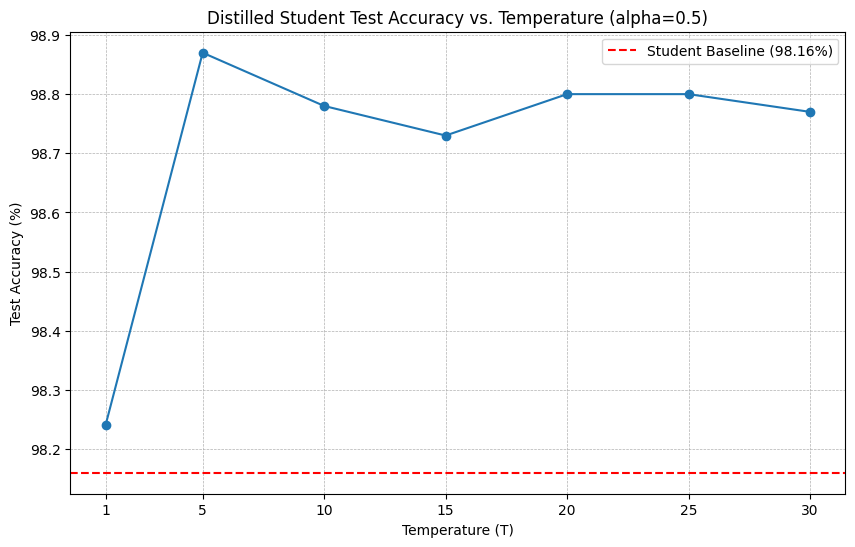


--- Temperature Analysis Summary (Test Accuracy) ---
T =  1: Accuracy = 98.24% (Improvement: +0.08%)
T =  5: Accuracy = 98.87% (Improvement: +0.71%)
T = 10: Accuracy = 98.78% (Improvement: +0.62%)
T = 15: Accuracy = 98.73% (Improvement: +0.57%)
T = 20: Accuracy = 98.80% (Improvement: +0.64%)
T = 25: Accuracy = 98.80% (Improvement: +0.64%)
T = 30: Accuracy = 98.77% (Improvement: +0.61%)

Optimal Temperature in tested range: T=5 with accuracy 98.87%


In [20]:
print("\n--- Starting Temperature Analysis ---")
temperature_results = {}


teacher_model_ta = TeacherNet().to(device)
teacher_model_ta.load_state_dict(torch.load(teacher_model_path, map_location=device))
teacher_model_ta.eval()

for T in TEMPERATURES_TO_TEST:
    print(f"\n--- Training with Temperature T = {T} (alpha={ALPHA}) ---")
    # Instantiate a fresh student model for each temperature
    student_temp = StudentNet().to(device)

    if OPTIMIZER_TYPE == 'Adam':
        optimizer = optim.Adam(student_temp.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, EPOCHS_STUDENT // 3), gamma=0.5)
    else: # Default to SGD
        optimizer = optim.SGD(student_temp.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR_DECAY_FACTOR)

    temp_train_losses = []
    temp_train_accs = []
    temp_val_accs = []

    # Distillation training loop for this temperature
    for epoch in range(EPOCHS_STUDENT):
        student_temp.train()
        batch_losses = []
        batch_accs = []
        progress_bar = tqdm(train_loader_student, desc=f"T={T} Epoch {epoch+1}/{EPOCHS_STUDENT}", leave=False)

        for i, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                teacher_logits = teacher_model_ta(inputs)
            student_logits = student_temp(inputs)
            loss = distillation_loss_fn(student_logits, teacher_logits, labels, T, ALPHA)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(student_logits.data, 1)
            accuracy = (predicted == labels).float().mean().item()
            batch_losses.append(loss.item())
            batch_accs.append(accuracy)

        epoch_train_loss = np.mean(batch_losses)
        epoch_train_acc = np.mean(batch_accs)
        temp_train_losses.append(epoch_train_loss)
        temp_train_accs.append(epoch_train_acc)

        epoch_val_acc = evaluate_accuracy(student_temp, val_loader_student, device)
        temp_val_accs.append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{EPOCHS_STUDENT} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        scheduler.step()

    print(f"--- Finished Training for T={T} ---")
    # Evaluate on Test set
    final_test_acc = evaluate_accuracy(student_temp, test_loader_student, device)
    temperature_results[T] = final_test_acc
    print(f"Final Test Accuracy for T={T}: {final_test_acc:.2f}%")

temps = sorted(temperature_results.keys())
accs = [temperature_results[t] for t in temps]

plt.figure(figsize=(10, 6))
plt.plot(temps, accs, marker='o', linestyle='-')
plt.axhline(student_baseline_test_accuracy, color='r', linestyle='--', label=f'Student Baseline ({student_baseline_test_accuracy:.2f}%)')
plt.title(f'Distilled Student Test Accuracy vs. Temperature (alpha={ALPHA})')
plt.xlabel('Temperature (T)')
plt.ylabel('Test Accuracy (%)')
plt.xticks(temps)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('results_refactored/temperature_vs_accuracy.png')
plt.show()

print("\n--- Temperature Analysis Summary (Test Accuracy) ---")
for T, acc in temperature_results.items():
    improvement = acc - student_baseline_test_accuracy
    print(f"T = {T:>2}: Accuracy = {acc:.2f}% (Improvement: {improvement:+.2f}%)")

best_T = max(temperature_results, key=temperature_results.get)
print(f"\nOptimal Temperature in tested range: T={best_T} with accuracy {temperature_results[best_T]:.2f}%")

In [21]:
TEMPERATURES_TO_TEST_1 = [2,2.5,3,4,4.5]


--- Starting Temperature Analysis ---

--- Training with Temperature T = 2 (alpha=0.5) ---


T=2 Epoch 1/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 0.7323, Train Acc: 0.9080, Val Acc: 95.30%


T=2 Epoch 2/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.2532, Train Acc: 0.9649, Val Acc: 97.13%


T=2 Epoch 3/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.1633, Train Acc: 0.9766, Val Acc: 97.43%


T=2 Epoch 4/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.1210, Train Acc: 0.9824, Val Acc: 97.80%


T=2 Epoch 5/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.0949, Train Acc: 0.9865, Val Acc: 98.10%


T=2 Epoch 6/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.0797, Train Acc: 0.9889, Val Acc: 98.23%


T=2 Epoch 7/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.0685, Train Acc: 0.9906, Val Acc: 98.17%


T=2 Epoch 8/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.0602, Train Acc: 0.9920, Val Acc: 98.23%


T=2 Epoch 9/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.0540, Train Acc: 0.9934, Val Acc: 98.27%


T=2 Epoch 10/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.0493, Train Acc: 0.9942, Val Acc: 98.33%


T=2 Epoch 11/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.0455, Train Acc: 0.9950, Val Acc: 98.23%


T=2 Epoch 12/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.0423, Train Acc: 0.9956, Val Acc: 98.33%


T=2 Epoch 13/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.0397, Train Acc: 0.9960, Val Acc: 98.30%


T=2 Epoch 14/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.0376, Train Acc: 0.9963, Val Acc: 98.37%


T=2 Epoch 15/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.0359, Train Acc: 0.9968, Val Acc: 98.27%


T=2 Epoch 16/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.0344, Train Acc: 0.9969, Val Acc: 98.37%


T=2 Epoch 17/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.0330, Train Acc: 0.9971, Val Acc: 98.40%


T=2 Epoch 18/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.0319, Train Acc: 0.9973, Val Acc: 98.37%


T=2 Epoch 19/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.0309, Train Acc: 0.9977, Val Acc: 98.40%


T=2 Epoch 20/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.0300, Train Acc: 0.9976, Val Acc: 98.47%


T=2 Epoch 21/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.0292, Train Acc: 0.9978, Val Acc: 98.47%


T=2 Epoch 22/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.0285, Train Acc: 0.9978, Val Acc: 98.50%


T=2 Epoch 23/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.0280, Train Acc: 0.9980, Val Acc: 98.50%


T=2 Epoch 24/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.0273, Train Acc: 0.9981, Val Acc: 98.40%


T=2 Epoch 25/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.0269, Train Acc: 0.9981, Val Acc: 98.50%


T=2 Epoch 26/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.0264, Train Acc: 0.9983, Val Acc: 98.53%


T=2 Epoch 27/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.0259, Train Acc: 0.9983, Val Acc: 98.57%


T=2 Epoch 28/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0256, Train Acc: 0.9984, Val Acc: 98.57%


T=2 Epoch 29/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0252, Train Acc: 0.9984, Val Acc: 98.53%


T=2 Epoch 30/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0249, Train Acc: 0.9984, Val Acc: 98.63%
--- Finished Training for T=2 ---
Final Test Accuracy for T=2: 98.52%

--- Training with Temperature T = 2.5 (alpha=0.5) ---


T=2.5 Epoch 1/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 0.9694, Train Acc: 0.9096, Val Acc: 95.90%


T=2.5 Epoch 2/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.3031, Train Acc: 0.9677, Val Acc: 96.93%


T=2.5 Epoch 3/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.1917, Train Acc: 0.9790, Val Acc: 97.77%


T=2.5 Epoch 4/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.1445, Train Acc: 0.9840, Val Acc: 98.00%


T=2.5 Epoch 5/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.1157, Train Acc: 0.9873, Val Acc: 98.07%


T=2.5 Epoch 6/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.0974, Train Acc: 0.9901, Val Acc: 98.30%


T=2.5 Epoch 7/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.0849, Train Acc: 0.9920, Val Acc: 98.23%


T=2.5 Epoch 8/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.0759, Train Acc: 0.9932, Val Acc: 98.20%


T=2.5 Epoch 9/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.0687, Train Acc: 0.9940, Val Acc: 98.37%


T=2.5 Epoch 10/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.0631, Train Acc: 0.9946, Val Acc: 98.37%


T=2.5 Epoch 11/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.0588, Train Acc: 0.9953, Val Acc: 98.50%


T=2.5 Epoch 12/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.0551, Train Acc: 0.9958, Val Acc: 98.43%


T=2.5 Epoch 13/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.0522, Train Acc: 0.9960, Val Acc: 98.40%


T=2.5 Epoch 14/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.0494, Train Acc: 0.9962, Val Acc: 98.53%


T=2.5 Epoch 15/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.0473, Train Acc: 0.9964, Val Acc: 98.53%


T=2.5 Epoch 16/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.0453, Train Acc: 0.9969, Val Acc: 98.57%


T=2.5 Epoch 17/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.0438, Train Acc: 0.9970, Val Acc: 98.50%


T=2.5 Epoch 18/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.0423, Train Acc: 0.9972, Val Acc: 98.63%


T=2.5 Epoch 19/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.0411, Train Acc: 0.9974, Val Acc: 98.57%


T=2.5 Epoch 20/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.0399, Train Acc: 0.9975, Val Acc: 98.57%


T=2.5 Epoch 21/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.0389, Train Acc: 0.9978, Val Acc: 98.63%


T=2.5 Epoch 22/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.0380, Train Acc: 0.9976, Val Acc: 98.60%


T=2.5 Epoch 23/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.0372, Train Acc: 0.9978, Val Acc: 98.70%


T=2.5 Epoch 24/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.0365, Train Acc: 0.9979, Val Acc: 98.63%


T=2.5 Epoch 25/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.0358, Train Acc: 0.9979, Val Acc: 98.70%


T=2.5 Epoch 26/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.0352, Train Acc: 0.9980, Val Acc: 98.73%


T=2.5 Epoch 27/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.0346, Train Acc: 0.9981, Val Acc: 98.60%


T=2.5 Epoch 28/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0341, Train Acc: 0.9981, Val Acc: 98.70%


T=2.5 Epoch 29/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0337, Train Acc: 0.9982, Val Acc: 98.70%


T=2.5 Epoch 30/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0332, Train Acc: 0.9982, Val Acc: 98.77%
--- Finished Training for T=2.5 ---
Final Test Accuracy for T=2.5: 98.55%

--- Training with Temperature T = 3 (alpha=0.5) ---


T=3 Epoch 1/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 1.1728, Train Acc: 0.9175, Val Acc: 96.30%


T=3 Epoch 2/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.3403, Train Acc: 0.9715, Val Acc: 97.63%


T=3 Epoch 3/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.2183, Train Acc: 0.9814, Val Acc: 98.03%


T=3 Epoch 4/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.1652, Train Acc: 0.9861, Val Acc: 98.10%


T=3 Epoch 5/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.1335, Train Acc: 0.9891, Val Acc: 98.13%


T=3 Epoch 6/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.1137, Train Acc: 0.9911, Val Acc: 98.37%


T=3 Epoch 7/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.0991, Train Acc: 0.9925, Val Acc: 98.27%


T=3 Epoch 8/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.0890, Train Acc: 0.9936, Val Acc: 98.30%


T=3 Epoch 9/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.0813, Train Acc: 0.9942, Val Acc: 98.60%


T=3 Epoch 10/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.0747, Train Acc: 0.9949, Val Acc: 98.47%


T=3 Epoch 11/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.0697, Train Acc: 0.9956, Val Acc: 98.40%


T=3 Epoch 12/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.0657, Train Acc: 0.9959, Val Acc: 98.60%


T=3 Epoch 13/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.0623, Train Acc: 0.9963, Val Acc: 98.60%


T=3 Epoch 14/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.0592, Train Acc: 0.9966, Val Acc: 98.70%


T=3 Epoch 15/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.0570, Train Acc: 0.9967, Val Acc: 98.63%


T=3 Epoch 16/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.0548, Train Acc: 0.9970, Val Acc: 98.53%


T=3 Epoch 17/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.0529, Train Acc: 0.9972, Val Acc: 98.63%


T=3 Epoch 18/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.0512, Train Acc: 0.9974, Val Acc: 98.67%


T=3 Epoch 19/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.0498, Train Acc: 0.9975, Val Acc: 98.70%


T=3 Epoch 20/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.0485, Train Acc: 0.9977, Val Acc: 98.67%


T=3 Epoch 21/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.0474, Train Acc: 0.9976, Val Acc: 98.67%


T=3 Epoch 22/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.0463, Train Acc: 0.9979, Val Acc: 98.63%


T=3 Epoch 23/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.0454, Train Acc: 0.9978, Val Acc: 98.67%


T=3 Epoch 24/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.0446, Train Acc: 0.9980, Val Acc: 98.67%


T=3 Epoch 25/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.0438, Train Acc: 0.9980, Val Acc: 98.77%


T=3 Epoch 26/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.0431, Train Acc: 0.9981, Val Acc: 98.63%


T=3 Epoch 27/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.0425, Train Acc: 0.9981, Val Acc: 98.70%


T=3 Epoch 28/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0418, Train Acc: 0.9982, Val Acc: 98.80%


T=3 Epoch 29/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0413, Train Acc: 0.9981, Val Acc: 98.77%


T=3 Epoch 30/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0408, Train Acc: 0.9983, Val Acc: 98.73%
--- Finished Training for T=3 ---
Final Test Accuracy for T=3: 98.73%

--- Training with Temperature T = 4 (alpha=0.5) ---


T=4 Epoch 1/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 1.5223, Train Acc: 0.9233, Val Acc: 96.77%


T=4 Epoch 2/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.3998, Train Acc: 0.9757, Val Acc: 97.80%


T=4 Epoch 3/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.2608, Train Acc: 0.9837, Val Acc: 98.17%


T=4 Epoch 4/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.1990, Train Acc: 0.9873, Val Acc: 98.57%


T=4 Epoch 5/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.1635, Train Acc: 0.9903, Val Acc: 98.40%


T=4 Epoch 6/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.1406, Train Acc: 0.9917, Val Acc: 98.47%


T=4 Epoch 7/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.1243, Train Acc: 0.9928, Val Acc: 98.67%


T=4 Epoch 8/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.1121, Train Acc: 0.9936, Val Acc: 98.67%


T=4 Epoch 9/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.1029, Train Acc: 0.9945, Val Acc: 98.70%


T=4 Epoch 10/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.0955, Train Acc: 0.9950, Val Acc: 98.60%


T=4 Epoch 11/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.0895, Train Acc: 0.9953, Val Acc: 98.70%


T=4 Epoch 12/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.0847, Train Acc: 0.9957, Val Acc: 98.70%


T=4 Epoch 13/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.0806, Train Acc: 0.9961, Val Acc: 98.63%


T=4 Epoch 14/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.0771, Train Acc: 0.9963, Val Acc: 98.73%


T=4 Epoch 15/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.0739, Train Acc: 0.9966, Val Acc: 98.70%


T=4 Epoch 16/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.0715, Train Acc: 0.9967, Val Acc: 98.60%


T=4 Epoch 17/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.0692, Train Acc: 0.9970, Val Acc: 98.63%


T=4 Epoch 18/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.0671, Train Acc: 0.9972, Val Acc: 98.70%


T=4 Epoch 19/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.0652, Train Acc: 0.9972, Val Acc: 98.63%


T=4 Epoch 20/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.0639, Train Acc: 0.9974, Val Acc: 98.73%


T=4 Epoch 21/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.0625, Train Acc: 0.9975, Val Acc: 98.70%


T=4 Epoch 22/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.0612, Train Acc: 0.9977, Val Acc: 98.70%


T=4 Epoch 23/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.0601, Train Acc: 0.9978, Val Acc: 98.70%


T=4 Epoch 24/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.0589, Train Acc: 0.9978, Val Acc: 98.73%


T=4 Epoch 25/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.0580, Train Acc: 0.9977, Val Acc: 98.77%


T=4 Epoch 26/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.0572, Train Acc: 0.9979, Val Acc: 98.63%


T=4 Epoch 27/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.0564, Train Acc: 0.9980, Val Acc: 98.73%


T=4 Epoch 28/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0557, Train Acc: 0.9979, Val Acc: 98.73%


T=4 Epoch 29/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0550, Train Acc: 0.9980, Val Acc: 98.77%


T=4 Epoch 30/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0544, Train Acc: 0.9980, Val Acc: 98.77%
--- Finished Training for T=4 ---
Final Test Accuracy for T=4: 98.81%

--- Training with Temperature T = 4.5 (alpha=0.5) ---


T=4.5 Epoch 1/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 1.6746, Train Acc: 0.9219, Val Acc: 96.57%


T=4.5 Epoch 2/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.4265, Train Acc: 0.9763, Val Acc: 97.87%


T=4.5 Epoch 3/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.2767, Train Acc: 0.9845, Val Acc: 98.17%


T=4.5 Epoch 4/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.2112, Train Acc: 0.9878, Val Acc: 98.30%


T=4.5 Epoch 5/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.1738, Train Acc: 0.9905, Val Acc: 98.47%


T=4.5 Epoch 6/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.1494, Train Acc: 0.9921, Val Acc: 98.53%


T=4.5 Epoch 7/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.1322, Train Acc: 0.9933, Val Acc: 98.63%


T=4.5 Epoch 8/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.1196, Train Acc: 0.9942, Val Acc: 98.50%


T=4.5 Epoch 9/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.1095, Train Acc: 0.9950, Val Acc: 98.60%


T=4.5 Epoch 10/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.1025, Train Acc: 0.9955, Val Acc: 98.60%


T=4.5 Epoch 11/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.0964, Train Acc: 0.9957, Val Acc: 98.53%


T=4.5 Epoch 12/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.0915, Train Acc: 0.9959, Val Acc: 98.63%


T=4.5 Epoch 13/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.0871, Train Acc: 0.9964, Val Acc: 98.73%


T=4.5 Epoch 14/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.0835, Train Acc: 0.9966, Val Acc: 98.67%


T=4.5 Epoch 15/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.0804, Train Acc: 0.9967, Val Acc: 98.73%


T=4.5 Epoch 16/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.0777, Train Acc: 0.9968, Val Acc: 98.70%


T=4.5 Epoch 17/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.0755, Train Acc: 0.9971, Val Acc: 98.63%


T=4.5 Epoch 18/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.0734, Train Acc: 0.9972, Val Acc: 98.67%


T=4.5 Epoch 19/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.0715, Train Acc: 0.9972, Val Acc: 98.70%


T=4.5 Epoch 20/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.0699, Train Acc: 0.9974, Val Acc: 98.73%


T=4.5 Epoch 21/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.0684, Train Acc: 0.9974, Val Acc: 98.77%


T=4.5 Epoch 22/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.0671, Train Acc: 0.9976, Val Acc: 98.67%


T=4.5 Epoch 23/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.0659, Train Acc: 0.9977, Val Acc: 98.70%


T=4.5 Epoch 24/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.0649, Train Acc: 0.9977, Val Acc: 98.67%


T=4.5 Epoch 25/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.0639, Train Acc: 0.9978, Val Acc: 98.70%


T=4.5 Epoch 26/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.0630, Train Acc: 0.9979, Val Acc: 98.67%


T=4.5 Epoch 27/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.0622, Train Acc: 0.9978, Val Acc: 98.70%


T=4.5 Epoch 28/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0614, Train Acc: 0.9979, Val Acc: 98.70%


T=4.5 Epoch 29/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0607, Train Acc: 0.9979, Val Acc: 98.70%


T=4.5 Epoch 30/30:   0%|          | 0/446 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0602, Train Acc: 0.9980, Val Acc: 98.73%
--- Finished Training for T=4.5 ---
Final Test Accuracy for T=4.5: 98.74%


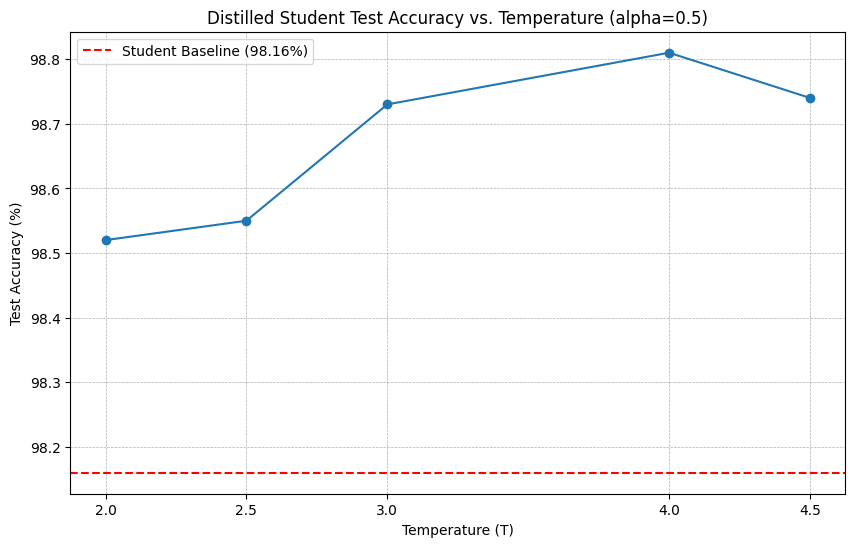


--- Temperature Analysis Summary (Test Accuracy) ---
T =  2: Accuracy = 98.52% (Improvement: +0.36%)
T = 2.5: Accuracy = 98.55% (Improvement: +0.39%)
T =  3: Accuracy = 98.73% (Improvement: +0.57%)
T =  4: Accuracy = 98.81% (Improvement: +0.65%)
T = 4.5: Accuracy = 98.74% (Improvement: +0.58%)

Optimal Temperature in tested range: T=4 with accuracy 98.81%


In [22]:
print("\n--- Starting Temperature Analysis ---")
temperature_results = {}
teacher_model_ta = TeacherNet().to(device)
teacher_model_ta.load_state_dict(torch.load(teacher_model_path, map_location=device))
teacher_model_ta.eval()

for T in TEMPERATURES_TO_TEST_1:
    print(f"\n--- Training with Temperature T = {T} (alpha={ALPHA}) ---")

    student_temp = StudentNet().to(device)

    if OPTIMIZER_TYPE == 'Adam':
        optimizer = optim.Adam(student_temp.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, EPOCHS_STUDENT // 3), gamma=0.5)
    else:
        optimizer = optim.SGD(student_temp.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR_DECAY_FACTOR)

    temp_train_losses = []
    temp_train_accs = []
    temp_val_accs = []

    for epoch in range(EPOCHS_STUDENT):
        student_temp.train()
        batch_losses = []
        batch_accs = []
        progress_bar = tqdm(train_loader_student, desc=f"T={T} Epoch {epoch+1}/{EPOCHS_STUDENT}", leave=False)

        for i, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                teacher_logits = teacher_model_ta(inputs)
            student_logits = student_temp(inputs)
            loss = distillation_loss_fn(student_logits, teacher_logits, labels, T, ALPHA)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(student_logits.data, 1)
            accuracy = (predicted == labels).float().mean().item()
            batch_losses.append(loss.item())
            batch_accs.append(accuracy)



        epoch_train_loss = np.mean(batch_losses)
        epoch_train_acc = np.mean(batch_accs)
        temp_train_losses.append(epoch_train_loss)
        temp_train_accs.append(epoch_train_acc)

        epoch_val_acc = evaluate_accuracy(student_temp, val_loader_student, device)
        temp_val_accs.append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{EPOCHS_STUDENT} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        scheduler.step()

    print(f"--- Finished Training for T={T} ---")

    final_test_acc = evaluate_accuracy(student_temp, test_loader_student, device)
    temperature_results[T] = final_test_acc
    print(f"Final Test Accuracy for T={T}: {final_test_acc:.2f}%")

temps = sorted(temperature_results.keys())
accs = [temperature_results[t] for t in temps]

plt.figure(figsize=(10, 6))
plt.plot(temps, accs, marker='o', linestyle='-')
plt.axhline(student_baseline_test_accuracy, color='r', linestyle='--', label=f'Student Baseline ({student_baseline_test_accuracy:.2f}%)')
plt.title(f'Distilled Student Test Accuracy vs. Temperature (alpha={ALPHA})')
plt.xlabel('Temperature (T)')
plt.ylabel('Test Accuracy (%)')
plt.xticks(temps)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('results_refactored/temperature_vs_accuracy.png')
plt.show()

print("\n--- Temperature Analysis Summary (Test Accuracy) ---")
for T, acc in temperature_results.items():
    improvement = acc - student_baseline_test_accuracy
    print(f"T = {T:>2}: Accuracy = {acc:.2f}% (Improvement: {improvement:+.2f}%)")

best_T = max(temperature_results, key=temperature_results.get)
print(f"\nOptimal Temperature in tested range: T={best_T} with accuracy {temperature_results[best_T]:.2f}%")

## 9. Requirement 4: Distillation with Omitted Class
 ### 9.1 Omitted Digit Baseline (as in source notebook, Optional but good comparison)

In [23]:
print(f"\n--- Training Student Baseline without seeing digit {OMITTED_DIGIT_BASELINE} ---")
student_baseline_omitted_bl = StudentNet().to(device)
train_loader_student_omitted_bl = get_omitted_digit_loader(train_dataset_student, OMITTED_DIGIT_BASELINE, BATCH_SIZE)

if OPTIMIZER_TYPE == 'Adam':
    optimizer = optim.Adam(student_baseline_omitted_bl.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, EPOCHS_STUDENT // 3), gamma=0.5)
else:
    optimizer = optim.SGD(student_baseline_omitted_bl.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR_DECAY_FACTOR)

criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCHS_STUDENT):
    student_baseline_omitted_bl.train()
    batch_losses = []
    batch_accs = []
    progress_bar = tqdm(train_loader_student_omitted_bl, desc=f"OmitBL {OMITTED_DIGIT_BASELINE} Epoch {epoch+1}/{EPOCHS_STUDENT}", leave=False)

    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = student_baseline_omitted_bl(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).float().mean().item()
        batch_losses.append(loss.item())
        batch_accs.append(accuracy)

    epoch_train_loss = np.mean(batch_losses)
    epoch_train_acc = np.mean(batch_accs)

    print(f"Epoch {epoch+1}/{EPOCHS_STUDENT} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
    scheduler.step()

print(f"--- Finished Baseline Training without digit {OMITTED_DIGIT_BASELINE} ---")


print(f"\nEvaluating baseline model trained without seeing digit '{OMITTED_DIGIT_BASELINE}'...")
overall_acc_omitted_bl, specific_acc_omitted_bl = evaluate_accuracy(
    student_baseline_omitted_bl,
    test_loader_student,
    device,
    class_specific_digit=OMITTED_DIGIT_BASELINE
)

print(f"\n--- Omitted Digit Baseline Results (Omitted Digit: {OMITTED_DIGIT_BASELINE}) ---")
print(f"Overall Test Accuracy: {overall_acc_omitted_bl:.2f}%")
print(f"Accuracy on unseen digit '{OMITTED_DIGIT_BASELINE}': {specific_acc_omitted_bl:.2f}% (Expected to be near 0)")


--- Training Student Baseline without seeing digit 4 ---
Dataset size after omitting digit 4: 51437


OmitBL 4 Epoch 1/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 0.3316, Train Acc: 0.9045


OmitBL 4 Epoch 2/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.1436, Train Acc: 0.9585


OmitBL 4 Epoch 3/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.1019, Train Acc: 0.9712


OmitBL 4 Epoch 4/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.0795, Train Acc: 0.9781


OmitBL 4 Epoch 5/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.0653, Train Acc: 0.9820


OmitBL 4 Epoch 6/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.0549, Train Acc: 0.9848


OmitBL 4 Epoch 7/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.0474, Train Acc: 0.9876


OmitBL 4 Epoch 8/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.0415, Train Acc: 0.9891


OmitBL 4 Epoch 9/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.0367, Train Acc: 0.9907


OmitBL 4 Epoch 10/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.0325, Train Acc: 0.9922


OmitBL 4 Epoch 11/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.0290, Train Acc: 0.9933


OmitBL 4 Epoch 12/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.0262, Train Acc: 0.9943


OmitBL 4 Epoch 13/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.0240, Train Acc: 0.9951


OmitBL 4 Epoch 14/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.0219, Train Acc: 0.9958


OmitBL 4 Epoch 15/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.0201, Train Acc: 0.9960


OmitBL 4 Epoch 16/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.0188, Train Acc: 0.9967


OmitBL 4 Epoch 17/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.0175, Train Acc: 0.9970


OmitBL 4 Epoch 18/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.0162, Train Acc: 0.9977


OmitBL 4 Epoch 19/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.0153, Train Acc: 0.9978


OmitBL 4 Epoch 20/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.0145, Train Acc: 0.9981


OmitBL 4 Epoch 21/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.0137, Train Acc: 0.9983


OmitBL 4 Epoch 22/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.0130, Train Acc: 0.9985


OmitBL 4 Epoch 23/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.0125, Train Acc: 0.9986


OmitBL 4 Epoch 24/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.0120, Train Acc: 0.9987


OmitBL 4 Epoch 25/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.0114, Train Acc: 0.9989


OmitBL 4 Epoch 26/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.0111, Train Acc: 0.9989


OmitBL 4 Epoch 27/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.0106, Train Acc: 0.9990


OmitBL 4 Epoch 28/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0103, Train Acc: 0.9991


OmitBL 4 Epoch 29/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0100, Train Acc: 0.9992


OmitBL 4 Epoch 30/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0097, Train Acc: 0.9992
--- Finished Baseline Training without digit 4 ---

Evaluating baseline model trained without seeing digit '4'...

--- Omitted Digit Baseline Results (Omitted Digit: 4) ---
Overall Test Accuracy: 88.61%
Accuracy on unseen digit '4': 0.00% (Expected to be near 0)


In [26]:
OMITTED_DIGIT_BASELINE_3=3

In [27]:
print(f"\n--- Training Student Baseline without seeing digit {OMITTED_DIGIT_BASELINE_3} ---")
student_baseline_omitted_bl = StudentNet().to(device)
train_loader_student_omitted_bl = get_omitted_digit_loader(train_dataset_student, OMITTED_DIGIT_BASELINE_3, BATCH_SIZE)

if OPTIMIZER_TYPE == 'Adam':
    optimizer = optim.Adam(student_baseline_omitted_bl.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, EPOCHS_STUDENT // 3), gamma=0.5)
else:
    optimizer = optim.SGD(student_baseline_omitted_bl.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR_DECAY_FACTOR)

criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCHS_STUDENT):
    student_baseline_omitted_bl.train()
    batch_losses = []
    batch_accs = []
    progress_bar = tqdm(train_loader_student_omitted_bl, desc=f"OmitBL {OMITTED_DIGIT_BASELINE_3} Epoch {epoch+1}/{EPOCHS_STUDENT}", leave=False)

    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = student_baseline_omitted_bl(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).float().mean().item()
        batch_losses.append(loss.item())
        batch_accs.append(accuracy)

    epoch_train_loss = np.mean(batch_losses)
    epoch_train_acc = np.mean(batch_accs)

    print(f"Epoch {epoch+1}/{EPOCHS_STUDENT} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
    scheduler.step()

print(f"--- Finished Baseline Training without digit {OMITTED_DIGIT_BASELINE_3} ---")


print(f"\nEvaluating baseline model trained without seeing digit '{OMITTED_DIGIT_BASELINE_3}'...")
overall_acc_omitted_bl, specific_acc_omitted_bl = evaluate_accuracy(
    student_baseline_omitted_bl,
    test_loader_student,
    device,
    class_specific_digit=OMITTED_DIGIT_BASELINE_3
)

print(f"\n--- Omitted Digit Baseline Results (Omitted Digit: {OMITTED_DIGIT_BASELINE_3}) ---")
print(f"Overall Test Accuracy: {overall_acc_omitted_bl:.2f}%")
print(f"Accuracy on unseen digit '{OMITTED_DIGIT_BASELINE_3}': {specific_acc_omitted_bl:.2f}% (Expected to be near 0)")


--- Training Student Baseline without seeing digit 3 ---
Dataset size after omitting digit 3: 51206


OmitBL 3 Epoch 1/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 0.3225, Train Acc: 0.9081


OmitBL 3 Epoch 2/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.1427, Train Acc: 0.9586


OmitBL 3 Epoch 3/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.1006, Train Acc: 0.9713


OmitBL 3 Epoch 4/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.0775, Train Acc: 0.9786


OmitBL 3 Epoch 5/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.0631, Train Acc: 0.9824


OmitBL 3 Epoch 6/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.0532, Train Acc: 0.9858


OmitBL 3 Epoch 7/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.0466, Train Acc: 0.9881


OmitBL 3 Epoch 8/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.0403, Train Acc: 0.9897


OmitBL 3 Epoch 9/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.0354, Train Acc: 0.9913


OmitBL 3 Epoch 10/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.0315, Train Acc: 0.9925


OmitBL 3 Epoch 11/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.0286, Train Acc: 0.9935


OmitBL 3 Epoch 12/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.0258, Train Acc: 0.9942


OmitBL 3 Epoch 13/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.0235, Train Acc: 0.9952


OmitBL 3 Epoch 14/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.0217, Train Acc: 0.9955


OmitBL 3 Epoch 15/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.0200, Train Acc: 0.9963


OmitBL 3 Epoch 16/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.0189, Train Acc: 0.9965


OmitBL 3 Epoch 17/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.0180, Train Acc: 0.9970


OmitBL 3 Epoch 18/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.0163, Train Acc: 0.9975


OmitBL 3 Epoch 19/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.0155, Train Acc: 0.9976


OmitBL 3 Epoch 20/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.0145, Train Acc: 0.9980


OmitBL 3 Epoch 21/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.0138, Train Acc: 0.9982


OmitBL 3 Epoch 22/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.0132, Train Acc: 0.9983


OmitBL 3 Epoch 23/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.0126, Train Acc: 0.9986


OmitBL 3 Epoch 24/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.0121, Train Acc: 0.9986


OmitBL 3 Epoch 25/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.0116, Train Acc: 0.9988


OmitBL 3 Epoch 26/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.0112, Train Acc: 0.9989


OmitBL 3 Epoch 27/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.0108, Train Acc: 0.9990


OmitBL 3 Epoch 28/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0105, Train Acc: 0.9990


OmitBL 3 Epoch 29/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0102, Train Acc: 0.9992


OmitBL 3 Epoch 30/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0099, Train Acc: 0.9992
--- Finished Baseline Training without digit 3 ---

Evaluating baseline model trained without seeing digit '3'...

--- Omitted Digit Baseline Results (Omitted Digit: 3) ---
Overall Test Accuracy: 88.24%
Accuracy on unseen digit '3': 0.00% (Expected to be near 0)


### 9.2 Distillation without seeing OMITTED_DIGIT

In [25]:
print(f"\n--- Starting Distillation without seeing digit {OMITTED_DIGIT} (T={DEFAULT_T}, alpha={ALPHA}) ---")


train_loader_student_omitted_kd = get_omitted_digit_loader(train_dataset_student, OMITTED_DIGIT, BATCH_SIZE)


student_omitted_kd = StudentNet().to(device)


teacher_model_omitted_kd = TeacherNet().to(device)
teacher_model_omitted_kd.load_state_dict(torch.load(teacher_model_path, map_location=device))
teacher_model_omitted_kd.eval()

if OPTIMIZER_TYPE == 'Adam':
    optimizer = optim.Adam(student_omitted_kd.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, EPOCHS_STUDENT // 3), gamma=0.5)
else:
    optimizer = optim.SGD(student_omitted_kd.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR_DECAY_FACTOR)

for epoch in range(EPOCHS_STUDENT):
    student_omitted_kd.train()
    batch_losses = []
    batch_accs = []

    progress_bar = tqdm(train_loader_student_omitted_kd, desc=f"OmitKD {OMITTED_DIGIT} Epoch {epoch+1}/{EPOCHS_STUDENT}", leave=False)

    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            teacher_logits = teacher_model_omitted_kd(inputs)
        student_logits = student_omitted_kd(inputs)
        loss = distillation_loss_fn(student_logits, teacher_logits, labels, DEFAULT_T, ALPHA)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(student_logits.data, 1)
        accuracy = (predicted == labels).float().mean().item()
        batch_losses.append(loss.item())
        batch_accs.append(accuracy)

    epoch_train_loss = np.mean(batch_losses)
    epoch_train_acc = np.mean(batch_accs)

    print(f"Epoch {epoch+1}/{EPOCHS_STUDENT} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
    scheduler.step()

print(f"--- Finished Distillation Training without digit {OMITTED_DIGIT} ---")

print(f"\nEvaluating distilled model trained without seeing digit '{OMITTED_DIGIT}' during distillation...")
overall_acc_omitted_kd, specific_acc_omitted_kd = evaluate_accuracy(
    student_omitted_kd,
    test_loader_student,
    device,
    class_specific_digit=OMITTED_DIGIT
)

print(f"\n--- Omitted Digit Distillation Results (Omitted Digit: {OMITTED_DIGIT}, T={DEFAULT_T}, alpha={ALPHA}) ---")
print(f"Overall Test Accuracy: {overall_acc_omitted_kd:.2f}%")
print(f"Accuracy on unseen digit '{OMITTED_DIGIT}': {specific_acc_omitted_kd:.2f}%")
print(f"Compare to baseline accuracy on unseen digit {OMITTED_DIGIT_BASELINE}: {specific_acc_omitted_bl:.2f}%")
print(f"\nNote: Distillation allowed the model to learn the unseen digit {OMITTED_DIGIT} much better than the baseline learned {OMITTED_DIGIT_BASELINE}.")
print(f"      Performance might improve further with bias correction (as mentioned in Hinton paper).")


--- Starting Distillation without seeing digit 3 (T=10, alpha=0.5) ---
Dataset size after omitting digit 3: 51206


OmitKD 3 Epoch 1/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 2.1549, Train Acc: 0.9321


OmitKD 3 Epoch 2/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.5403, Train Acc: 0.9803


OmitKD 3 Epoch 3/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.3662, Train Acc: 0.9867


OmitKD 3 Epoch 4/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.2896, Train Acc: 0.9896


OmitKD 3 Epoch 5/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.2425, Train Acc: 0.9916


OmitKD 3 Epoch 6/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.2150, Train Acc: 0.9925


OmitKD 3 Epoch 7/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.1944, Train Acc: 0.9932


OmitKD 3 Epoch 8/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.1775, Train Acc: 0.9937


OmitKD 3 Epoch 9/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.1675, Train Acc: 0.9947


OmitKD 3 Epoch 10/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.1545, Train Acc: 0.9950


OmitKD 3 Epoch 11/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.1469, Train Acc: 0.9955


OmitKD 3 Epoch 12/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.1404, Train Acc: 0.9957


OmitKD 3 Epoch 13/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.1352, Train Acc: 0.9959


OmitKD 3 Epoch 14/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.1303, Train Acc: 0.9962


OmitKD 3 Epoch 15/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.1257, Train Acc: 0.9964


OmitKD 3 Epoch 16/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.1224, Train Acc: 0.9964


OmitKD 3 Epoch 17/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.1190, Train Acc: 0.9966


OmitKD 3 Epoch 18/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.1165, Train Acc: 0.9965


OmitKD 3 Epoch 19/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.1137, Train Acc: 0.9966


OmitKD 3 Epoch 20/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.1120, Train Acc: 0.9968


OmitKD 3 Epoch 21/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.1096, Train Acc: 0.9970


OmitKD 3 Epoch 22/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.1075, Train Acc: 0.9971


OmitKD 3 Epoch 23/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.1059, Train Acc: 0.9972


OmitKD 3 Epoch 24/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.1045, Train Acc: 0.9971


OmitKD 3 Epoch 25/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.1028, Train Acc: 0.9974


OmitKD 3 Epoch 26/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.1015, Train Acc: 0.9973


OmitKD 3 Epoch 27/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.1005, Train Acc: 0.9975


OmitKD 3 Epoch 28/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0992, Train Acc: 0.9975


OmitKD 3 Epoch 29/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0984, Train Acc: 0.9975


OmitKD 3 Epoch 30/30:   0%|          | 0/401 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0974, Train Acc: 0.9976
--- Finished Distillation Training without digit 3 ---

Evaluating distilled model trained without seeing digit '3' during distillation...

--- Omitted Digit Distillation Results (Omitted Digit: 3, T=10, alpha=0.5) ---
Overall Test Accuracy: 98.56%
Accuracy on unseen digit '3': 95.05%
Compare to baseline accuracy on unseen digit 4: 0.00%

Note: Distillation allowed the model to learn the unseen digit 3 much better than the baseline learned 4.
      Performance might improve further with bias correction (as mentioned in Hinton paper).


In [28]:
print(f"\n--- Starting Distillation without seeing digit {4} (T={DEFAULT_T}, alpha={ALPHA}) ---")


train_loader_student_omitted_kd = get_omitted_digit_loader(train_dataset_student, 4, BATCH_SIZE)

student_omitted_kd = StudentNet().to(device)

teacher_model_omitted_kd = TeacherNet().to(device)
teacher_model_omitted_kd.load_state_dict(torch.load(teacher_model_path, map_location=device))
teacher_model_omitted_kd.eval()


if OPTIMIZER_TYPE == 'Adam':
    optimizer = optim.Adam(student_omitted_kd.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=max(1, EPOCHS_STUDENT // 3), gamma=0.5)
else:
    optimizer = optim.SGD(student_omitted_kd.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR_DECAY_FACTOR)

for epoch in range(EPOCHS_STUDENT):
    student_omitted_kd.train()
    batch_losses = []
    batch_accs = []

    progress_bar = tqdm(train_loader_student_omitted_kd, desc=f"OmitKD {4} Epoch {epoch+1}/{EPOCHS_STUDENT}", leave=False)

    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            teacher_logits = teacher_model_omitted_kd(inputs)
        student_logits = student_omitted_kd(inputs)
        loss = distillation_loss_fn(student_logits, teacher_logits, labels, DEFAULT_T, ALPHA)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(student_logits.data, 1)
        accuracy = (predicted == labels).float().mean().item()
        batch_losses.append(loss.item())
        batch_accs.append(accuracy)

    epoch_train_loss = np.mean(batch_losses)
    epoch_train_acc = np.mean(batch_accs)

    print(f"Epoch {epoch+1}/{EPOCHS_STUDENT} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
    scheduler.step()

print(f"--- Finished Distillation Training without digit {4} ---")
print(f"\nEvaluating distilled model trained without seeing digit '{4}' during distillation...")
overall_acc_omitted_kd, specific_acc_omitted_kd = evaluate_accuracy(
    student_omitted_kd,
    test_loader_student,
    device,
    class_specific_digit=4
)

print(f"\n--- Omitted Digit Distillation Results (Omitted Digit: {4}, T={DEFAULT_T}, alpha={ALPHA}) ---")
print(f"Overall Test Accuracy: {overall_acc_omitted_kd:.2f}%")
print(f"Accuracy on unseen digit '{4}': {specific_acc_omitted_kd:.2f}%")
print(f"Compare to baseline accuracy on unseen digit {OMITTED_DIGIT_BASELINE}: {specific_acc_omitted_bl:.2f}%")
print(f"\nNote: Distillation allowed the model to learn the unseen digit {4} much better than the baseline learned {OMITTED_DIGIT_BASELINE}.")
print(f"      Performance might improve further with bias correction (as mentioned in Hinton paper).")


--- Starting Distillation without seeing digit 4 (T=10, alpha=0.5) ---
Dataset size after omitting digit 4: 51437


OmitKD 4 Epoch 1/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 2.1576, Train Acc: 0.9236


OmitKD 4 Epoch 2/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.5520, Train Acc: 0.9795


OmitKD 4 Epoch 3/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.3767, Train Acc: 0.9853


OmitKD 4 Epoch 4/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.2932, Train Acc: 0.9886


OmitKD 4 Epoch 5/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.2467, Train Acc: 0.9908


OmitKD 4 Epoch 6/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.2148, Train Acc: 0.9921


OmitKD 4 Epoch 7/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.1937, Train Acc: 0.9930


OmitKD 4 Epoch 8/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.1773, Train Acc: 0.9940


OmitKD 4 Epoch 9/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.1654, Train Acc: 0.9945


OmitKD 4 Epoch 10/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.1551, Train Acc: 0.9949


OmitKD 4 Epoch 11/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.1468, Train Acc: 0.9953


OmitKD 4 Epoch 12/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.1403, Train Acc: 0.9956


OmitKD 4 Epoch 13/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.1343, Train Acc: 0.9958


OmitKD 4 Epoch 14/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.1298, Train Acc: 0.9961


OmitKD 4 Epoch 15/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.1254, Train Acc: 0.9961


OmitKD 4 Epoch 16/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.1217, Train Acc: 0.9963


OmitKD 4 Epoch 17/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.1187, Train Acc: 0.9966


OmitKD 4 Epoch 18/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.1160, Train Acc: 0.9966


OmitKD 4 Epoch 19/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.1133, Train Acc: 0.9967


OmitKD 4 Epoch 20/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.1110, Train Acc: 0.9969


OmitKD 4 Epoch 21/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.1089, Train Acc: 0.9970


OmitKD 4 Epoch 22/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.1070, Train Acc: 0.9972


OmitKD 4 Epoch 23/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.1054, Train Acc: 0.9971


OmitKD 4 Epoch 24/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.1038, Train Acc: 0.9972


OmitKD 4 Epoch 25/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.1024, Train Acc: 0.9974


OmitKD 4 Epoch 26/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.1012, Train Acc: 0.9974


OmitKD 4 Epoch 27/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.1000, Train Acc: 0.9974


OmitKD 4 Epoch 28/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.0988, Train Acc: 0.9975


OmitKD 4 Epoch 29/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.0979, Train Acc: 0.9975


OmitKD 4 Epoch 30/30:   0%|          | 0/402 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.0969, Train Acc: 0.9975
--- Finished Distillation Training without digit 4 ---

Evaluating distilled model trained without seeing digit '4' during distillation...

--- Omitted Digit Distillation Results (Omitted Digit: 4, T=10, alpha=0.5) ---
Overall Test Accuracy: 98.64%
Accuracy on unseen digit '4': 95.62%
Compare to baseline accuracy on unseen digit 4: 0.00%

Note: Distillation allowed the model to learn the unseen digit 4 much better than the baseline learned 4.
      Performance might improve further with bias correction (as mentioned in Hinton paper).
